In [1]:
from sklearn.metrics import r2_score
from deltalake import DeltaTable
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import itertools
import os

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
four_wheels = lambda x, y: [f'{x}_rear_left_{y}', f'{x}_rear_right_{y}', f'{x}_front_left_{y}', f'{x}_front_right_{y}']

In [4]:
participants = DeltaTable('/Users/ignasi/Documents/_00_BDMTA_/bdmta-tfm/data-managment/delta/participants')
participants_df = participants.to_pandas()
participants_df = participants_df[['session_type', 'driver', 'name', 'team']]
participants_df.drop_duplicates(inplace=True)

In [5]:
participants_df[participants_df['session_type'] == 'race-redbull-ring-e3']

,session_type,driver,name,team
0,race-redbull-ring-e3,0,Nico Hulkenburg,Haas
1,race-redbull-ring-e3,1,Max Verstappen,Red Bull Racing
2,race-redbull-ring-e3,2,Lance Stroll,Aston Martin
3,race-redbull-ring-e3,3,Pierre Gasly,Alpine
4,race-redbull-ring-e3,4,Carlos Sainz,Ferrari
5,race-redbull-ring-e3,5,Esteban Ocon,Alpine
6,race-redbull-ring-e3,6,Charles Leclerc,Ferrari
7,race-redbull-ring-e3,7,Lewis Hamilton,Mercedes
8,race-redbull-ring-e3,8,Alexander Albon,Williams
9,race-redbull-ring-e3,9,Oscar Piastri,McLaren


In [6]:
dfs = []
for file_name in os.listdir('delta/segment_results'):
    if file_name.endswith('.parquet'):
        dfs.append(pd.read_parquet('delta/segment_results/' + file_name))
df = pd.concat(dfs)

In [7]:
df = df.join(participants_df, on='driver', rsuffix='p_')
df.rename({'p_name': 'name', 'p_team': 'team'}, axis='columns', inplace=True)

In [8]:
df['lap_time'] = df['end_lap'] - df['start_lap']
df = df[df['lap_time'] < 90]
df = df.dropna(axis='columns', how='any')

In [9]:
for i in ['rear_left', 'rear_right', 'front_left', 'front_right']:
    df[f'{i}_tyresDamage'] = df[f'max_{i}_tyresDamage'] - df[f'min_{i}_tyresDamage']
    
df['tyres_damage'] = df[['rear_left_tyresDamage', 'rear_right_tyresDamage', 'front_left_tyresDamage', 'front_right_tyresDamage']].apply(lambda x: np.mean(x), axis=1)
df = df[df['tyres_damage'] < 5]

In [10]:
stats_by_driver_df = df.groupby(['name', 'segment'])['tyres_damage'].describe()
stats_by_driver_df

count      mean       std   min     25%    50%  \
name            segment                                                   
Alexander Albon 1.0       32.0  0.070312  0.114201  0.00  0.0000  0.000   
                2.0       34.0  0.102941  0.164197  0.00  0.0000  0.000   
                3.0       34.0  0.139706  0.186588  0.00  0.0000  0.000   
                4.0       34.0  0.036765  0.089873  0.00  0.0000  0.000   
                5.0       34.0  0.176471  0.189990  0.00  0.0000  0.250   
...                        ...       ...       ...   ...     ...    ...   
Yuki Tsunoda    9.0        6.0  0.416667  0.204124  0.25  0.2500  0.375   
                10.0       6.0  0.083333  0.129099  0.00  0.0000  0.000   
                11.0       6.0  0.000000  0.000000  0.00  0.0000  0.000   
                12.0       6.0  0.250000  0.273861  0.00  0.0625  0.250   
                13.0       6.0  0.166667  0.302765  0.00  0.0000  0.000   

                            75%   max  
name            segment                
Alexander Albon 1.0      0.2500  0.25  
                2.0      0.2500  0.75  
                3.0      0.2500  0.75  
                4.0      0.0000  0.25  
                5.0      0.2500  0.75  
...                         ...   ...  
Yuki Tsunoda    9.0      0.5000  0.75  
                10.0     0.1875  0.25  
                11.0     0.0000  0.00  
                12.0     0.2500  0.75  
                13.0     0.1875  0.75  

[286 rows x 8 columns]

In [11]:
waypoints_df[waypoints_df.segment == 2]['perc'].max()

NameError: name 'waypoints_df' is not defined

In [173]:
from track.layouts import redbull_ring
waypoints_df = pd.DataFrame(redbull_ring.waypoints, columns=['x', 'y', 'z', 'perc', 'segment'])
segments = []
for segment in waypoints_df.segment.unique():
    segments.append([segment, max(waypoints_df[waypoints_df.segment == segment]['perc']) - min(waypoints_df[waypoints_df.segment == segment]['perc'])])
segments[0][1] = 1 - np.sum([i[1] for i in segments[1:]])
segments

[[1.0, 0.15325449668840097],
 [2.0, 0.01659998420080662],
 [3.0, 0.20401761331446228],
 [4.0, 0.01697696414332117],
 [5.0, 0.16812369075546507],
 [6.0, 0.054210973014645725],
 [7.0, 0.021796831597408528],
 [8.0, 0.09355733174285319],
 [9.0, 0.049100923889274006],
 [10.0, 0.05921473403631172],
 [11.0, 0.06924189322704055],
 [12.0, 0.05259239147506667],
 [13.0, 0.04131217191494352]]

<Figure size 1400x1200 with 0 Axes>

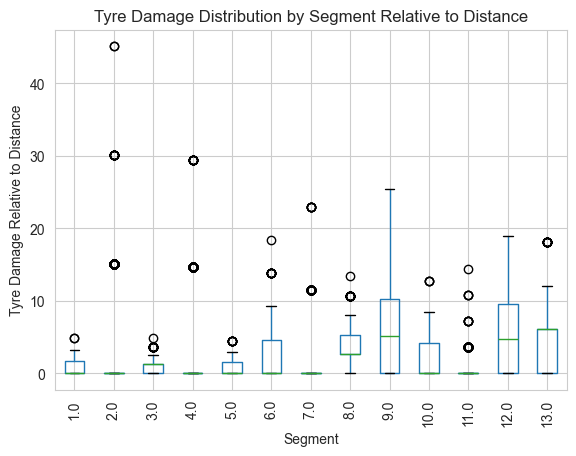

In [176]:
df['tyres_damage_by_segment'] = df.apply(lambda x: x['tyres_damage'] / segments[int(x['segment']-1)][1], axis=1)
plt.figure(figsize=(14, 12))
df.boxplot(column='tyres_damage_by_segment', by='segment')
plt.title('Tyre Damage Distribution by Segment Relative to Distance')
plt.suptitle('')  # Remove the default suptitle
plt.xlabel('Segment')
plt.ylabel('Tyre Damage Relative to Distance')
plt.xticks(rotation=90)
plt.show()

In [130]:
tyresDamage = df.groupby(['name', 'segment'], as_index=False)[['rear_left_tyresDamage', 'rear_right_tyresDamage', 'front_left_tyresDamage', 'front_right_tyresDamage']].mean()

/var/folders/39/cs55k1492gsb818wts2_nqch0000gn/T/ipykernel_11530/1016263883.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_colors)


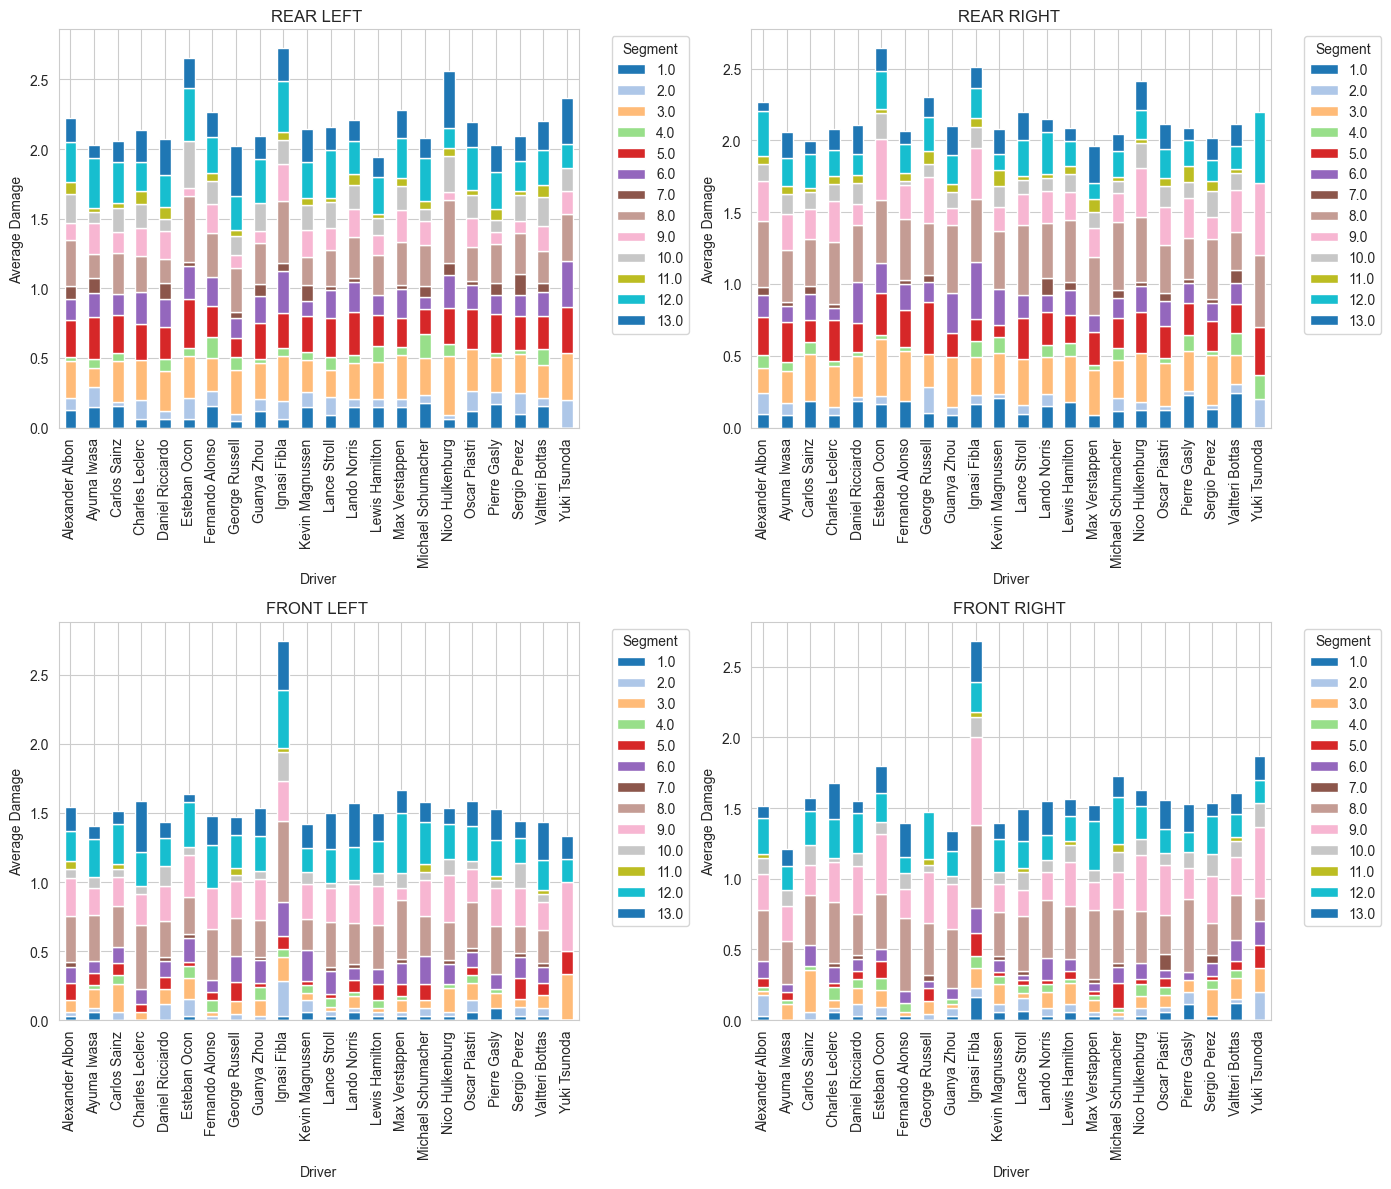

In [131]:
import matplotlib.pyplot as plt

# Create a color palette with at least 20 colors
n_colors = len(tyresDamage['segment'].unique())
colors = plt.cm.get_cmap('tab20', n_colors)

fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

columns = ['rear_left_tyresDamage', 'rear_right_tyresDamage', 'front_left_tyresDamage', 'front_right_tyresDamage']

for i, col in enumerate(columns):
    ax = axs[i]
    pivot_df = tyresDamage.pivot(index='name', columns='segment', values=col).fillna(0)
    
    # Use the colormap to get the required colors
    color_list = [colors(j) for j in range(12)]
    
    pivot_df.plot(kind='bar', stacked=True, ax=ax, color=color_list)
    ax.set_title(f'{col.replace("_", " ")[:-11].upper()}')
    ax.set_xlabel('Driver')
    ax.set_ylabel('Average Damage')
    ax.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [64]:
means = []
for driver in df['name'].unique():
    means.append([driver, df[df['name'] == driver]['lap_time'].describe()['75%']-df[df['name'] == driver]['lap_time'].describe()['25%']])
means.sort(key=lambda x: x[1])
means

[['Yuki Tsunoda', 0.60052490234375],
 ['Alexander Albon', 0.8007659912109375],
 ['Carlos Sainz', 0.80078125],
 ['Daniel Ricciardo', 0.88421630859375],
 ['Lance Stroll', 0.900909423828125],
 ['Max Verstappen', 0.951202392578125],
 ['Esteban Ocon', 1.00091552734375],
 ['Oscar Piastri', 1.051422119140625],
 ['Sergio Perez', 1.10101318359375],
 ['Fernando Alonso', 1.1011505126953125],
 ['Charles Leclerc', 1.134307861328125],
 ['Michael Schumacher', 1.18438720703125],
 ['Valtteri Bottas', 1.18463134765625],
 ['Lando Norris', 1.2510986328125],
 ['Kevin Magnussen', 1.30133056640625],
 ['Pierre Gasly', 1.3138809204101562],
 ['Ayuma Iwasa', 1.386810302734375],
 ['Lewis Hamilton', 1.401397705078125],
 ['Nico Hulkenburg', 1.478759765625],
 ['George Russell', 1.50152587890625],
 ['Ignasi Fibla', 1.90185546875],
 ['Guanya Zhou', 2.0018310546875]]

<Figure size 1400x1200 with 0 Axes>

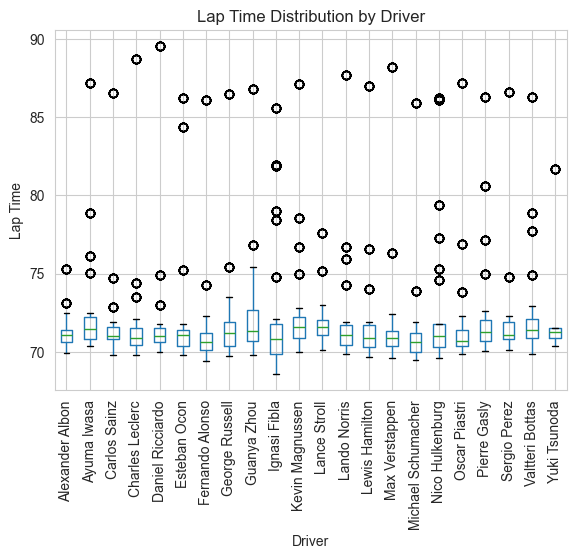

In [19]:
plt.figure(figsize=(14, 12))
df.boxplot(column='lap_time', by='name')
plt.title('Lap Time Distribution by Driver')
plt.suptitle('')  # Remove the default suptitle
plt.xlabel('Driver')
plt.ylabel('Lap Time')
plt.xticks(rotation=90)
plt.show()

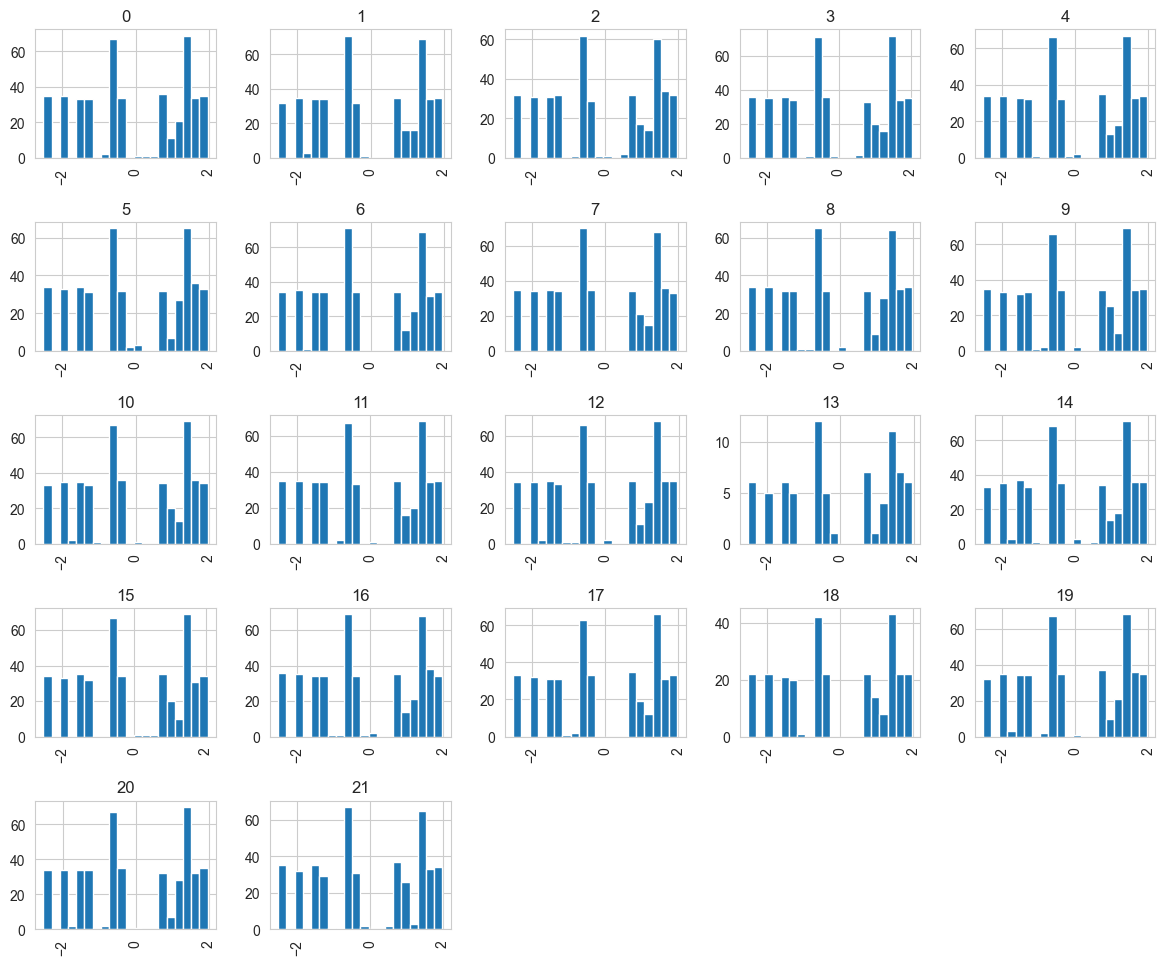

In [20]:
df[['driver', 'mean_yaw']].hist('mean_yaw', by='driver', bins=20, figsize=(14, 12))
plt.show()

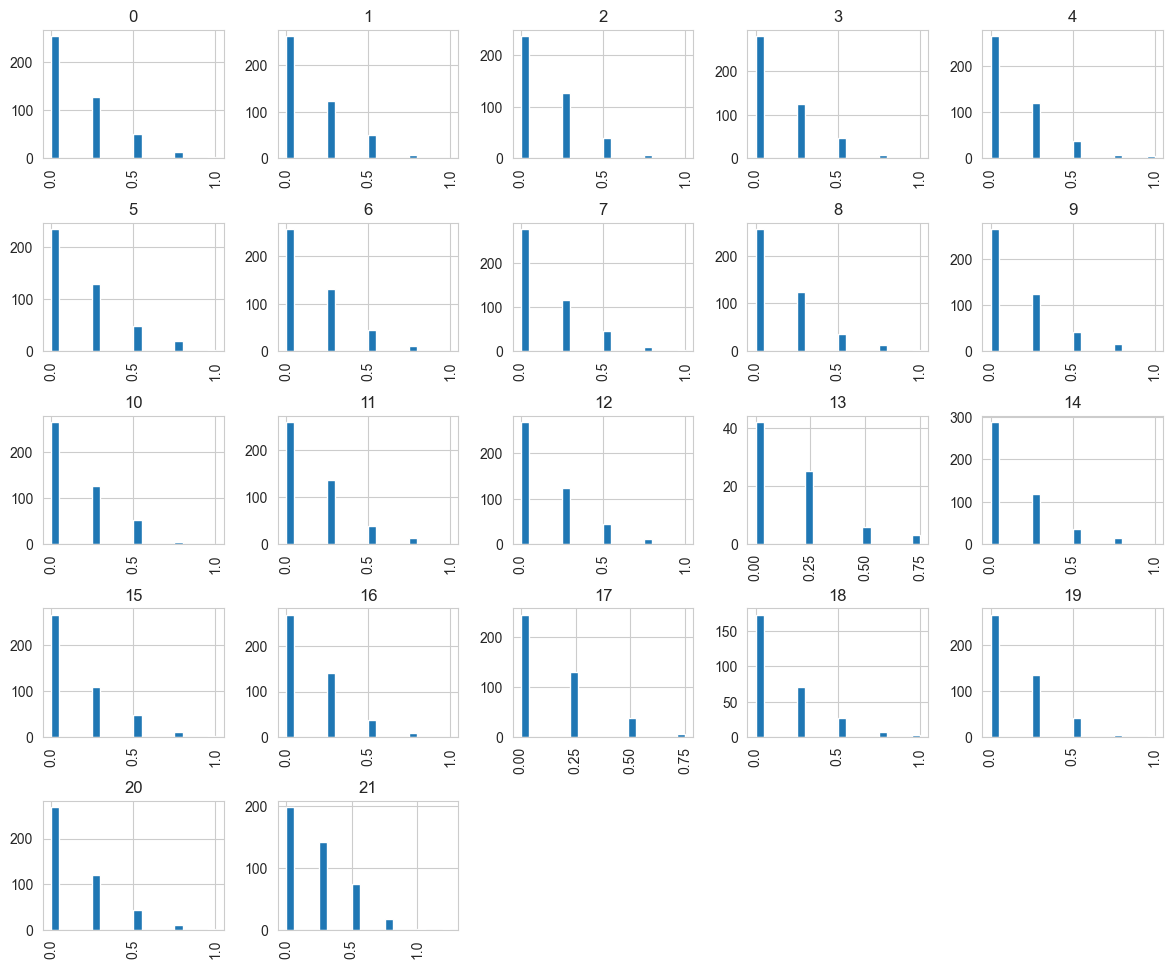

In [21]:
df[['driver', 'tyres_damage']].hist('tyres_damage', by='driver', bins=20, figsize=(14, 12))
plt.show()

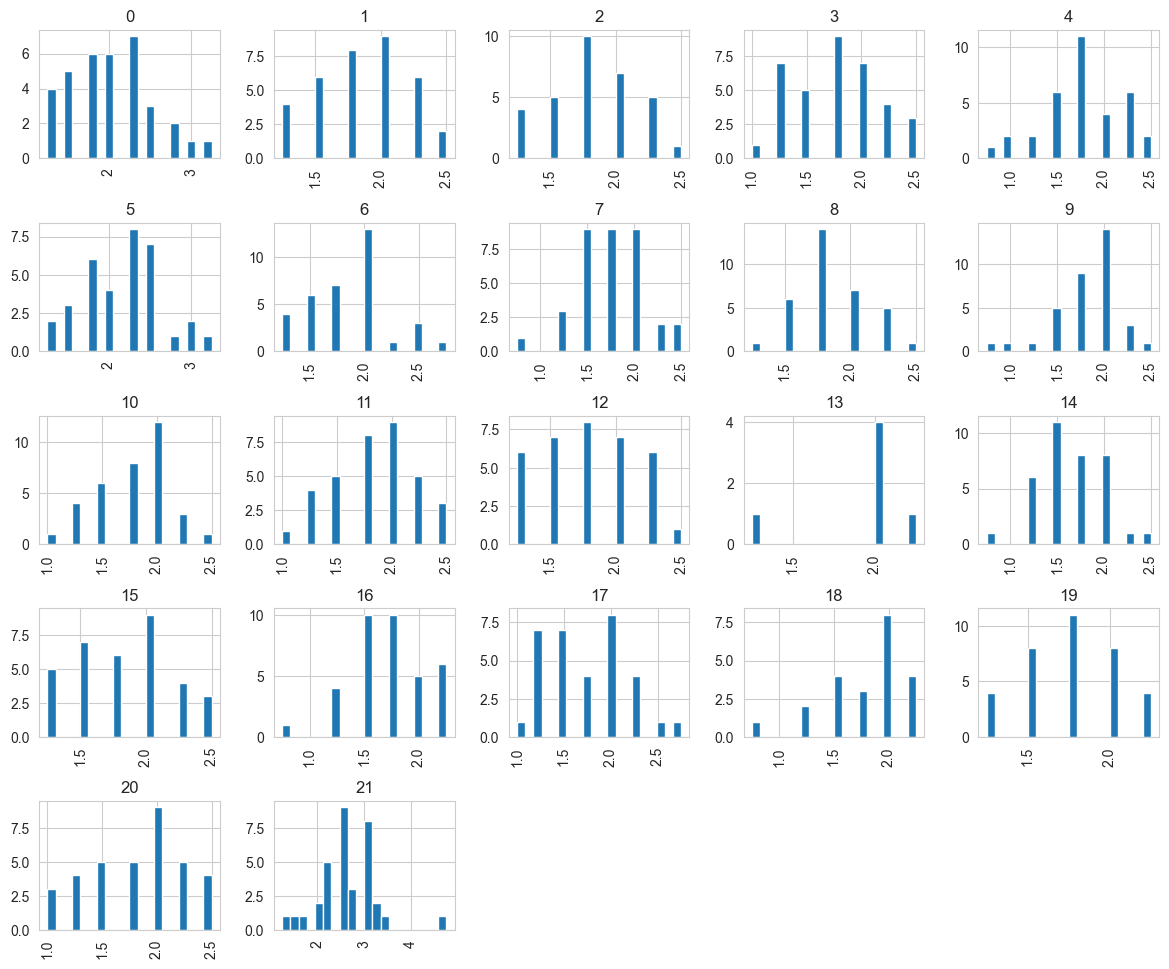

In [22]:
df.groupby(['driver', 'start_lap', 'end_lap'], as_index=False).sum()[['driver', 'tyres_damage']].hist('tyres_damage', by='driver', bins=20, figsize=(14, 12))
plt.show()

In [23]:
tyreConsumption = df.groupby(['driver', 'start_lap', 'end_lap'], as_index=False).sum()[['driver', 'start_lap', 'end_lap', 'tyres_damage']].rename(columns={'tyres_damage': 'tyres_damage_lap'}).reset_index()

df = df.merge(tyreConsumption, how='right', on=['driver', 'start_lap', 'end_lap'])

In [24]:
segments = df['segment'].unique()
columns = [col for col in df.columns if col not in ['driver', 'start_lap', 'end_lap', 'segment', 'lap_time', 'index', 'tyres_damage_lap']]

pivoted = df.pivot_table(
    index=['driver', 'start_lap', 'end_lap'],
    columns='segment',
    values=columns,
    aggfunc='first'
)

pivoted.columns = [f'{col}_{int(seg)}' for col, seg in pivoted.columns]
pivoted = pivoted.reset_index()
main_df = df[['driver', 'start_lap', 'end_lap', 'tyres_damage_lap', 'lap_time']].drop_duplicates()
pivoted_df = main_df.merge(pivoted, on=['driver', 'start_lap', 'end_lap'], how='left')

In [138]:
df_corr = pivoted_df.corr(numeric_only=True)

In [139]:
df_corr[['tyres_damage_lap', 'lap_time']]

,tyres_damage_lap,lap_time
driver,0.051892,0.018902
start_lap,-0.242036,-0.119718
end_lap,-0.242767,-0.115629
tyres_damage_lap,1.000000,-0.147564
lap_time,-0.147564,1.000000
...,...,...
tyres_damage_by_segment_9,0.084109,0.069038
tyres_damage_by_segment_10,-0.001455,0.028297
tyres_damage_by_segment_11,0.002292,-0.037905
tyres_damage_by_segment_12,0.247006,-0.074299


In [140]:
selected_columns = [
    'max_g_force_lateral',
    'min_g_force_lateral',
    'mean_g_force_lateral',
    'stddev_g_force_lateral',
    'max_yaw',
    'min_yaw',
    'mean_yaw',
    'stddev_yaw',
]

selected_columns_with_segments = [f'{col}_{int(seg)}' for col, seg in itertools.product(selected_columns, segments)]

<Axes: xlabel='tyres_damage_lap', ylabel='lap_time'>

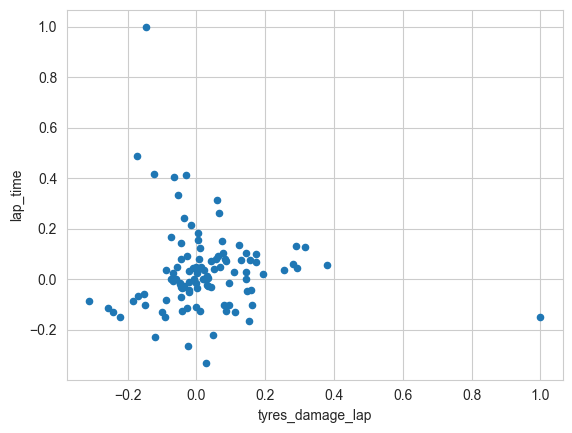

In [141]:
pivoted_df[['tyres_damage_lap', 'lap_time'] + selected_columns_with_segments].corr().plot.scatter(x='tyres_damage_lap', y='lap_time')

In [142]:
filtered_df = pivoted_df[['tyres_damage_lap', 'lap_time'] + selected_columns_with_segments].dropna()
X = filtered_df[selected_columns_with_segments].to_numpy()

In [143]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
df_2dims = pca.fit_transform(X)

df_2dims = pd.DataFrame(df_2dims, columns=[f'd{i}' for i in range(5)])
df_2dims['lap_time'] = filtered_df['lap_time'].to_numpy()
df_2dims['tyres_damage_lap'] = filtered_df['tyres_damage_lap'].to_numpy()

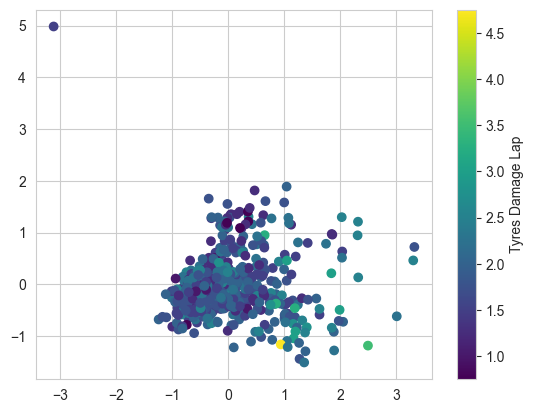

In [144]:
scatter = plt.scatter(df_2dims['d0'], df_2dims['d3'], 
                      c=df_2dims['tyres_damage_lap'], 
                      cmap='viridis')

plt.colorbar(scatter, label='Tyres Damage Lap')

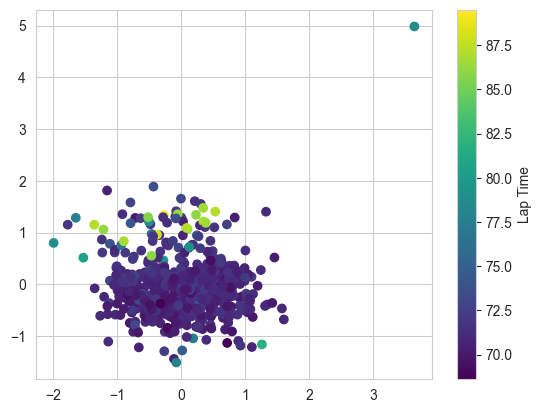

In [145]:
scatter = plt.scatter(df_2dims['d2'], df_2dims['d3'], 
                      c=df_2dims['lap_time'], 
                      cmap='viridis')

plt.colorbar(scatter, label='Lap Time')

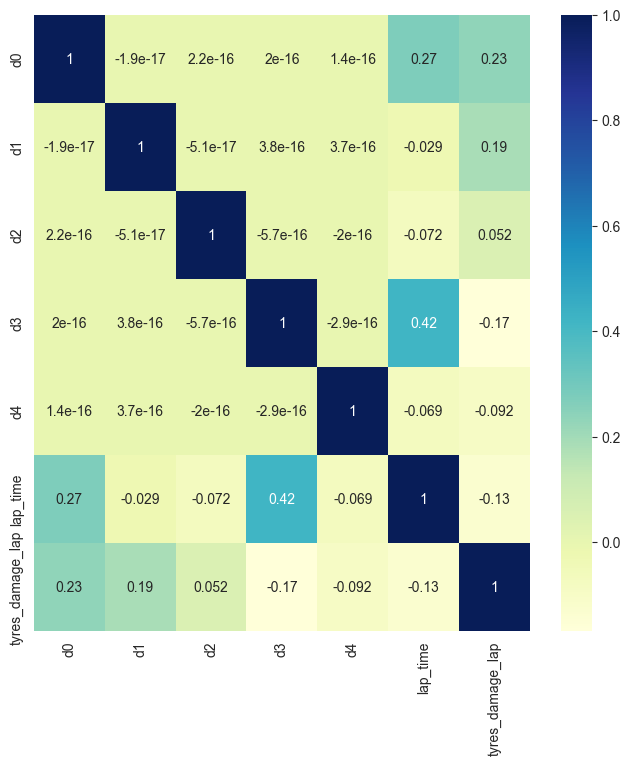

In [146]:
plt.figure(figsize=(8, 8))
dataplot = sb.heatmap(df_2dims.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.show()

In [147]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['tyres_damage_lap'])
df_2dims['tyres_damage_lap_reg'] = reg.predict(df_2dims[[f'd{i}' for i in range(5)]])
r2_score(df_2dims['tyres_damage_lap'].to_numpy(), df_2dims['tyres_damage_lap_reg'].to_numpy())

0.12923660985661556

In [148]:
reg = LinearRegression().fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['lap_time'])
df_2dims['lap_time_reg'] = reg.predict(df_2dims[[f'd{i}' for i in range(5)]])
r2_score(df_2dims['lap_time'].to_numpy(), df_2dims['lap_time_reg'].to_numpy())

0.2608118705585609

In [149]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=1.0, degree=10)
krr.fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['tyres_damage_lap'])
df_2dims['tyres_damage_lap_kr'] = krr.predict(df_2dims[[f'd{i}' for i in range(5)]])
r2_score(df_2dims['tyres_damage_lap'].to_numpy(), df_2dims['tyres_damage_lap_kr'].to_numpy())

-16.85541261685301

In [150]:
krr = KernelRidge(alpha=1.0, degree=10)
krr.fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['lap_time'])
df_2dims['lap_time_kr'] = krr.predict(df_2dims[[f'd{i}' for i in range(5)]])
r2_score(df_2dims['lap_time'].to_numpy(), df_2dims['lap_time_kr'].to_numpy())

-633.723252811042

In [151]:
df_2dims['tyres_damage_lap'].unique()

array([2.5 , 3.25, 2.75, 3.  , 2.  , 1.25, 1.5 , 2.25, 1.75, 1.  , 0.75,
       4.75, 3.5 ], dtype=float32)

In [152]:
bins = [0, 1, 2, 3, 4, 5]
df_2dims['tyres_damage_digitize'] = np.digitize(df_2dims['tyres_damage_lap'], bins) - 1

In [153]:
from sklearn import svm
clf = svm.SVC().fit(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['tyres_damage_digitize'])
clf.score(df_2dims[[f'd{i}' for i in range(5)]], df_2dims['tyres_damage_digitize'])

0.5986159169550173

In [154]:
pivoted_df[pivoted_df['driver'] == 21][['start_lap', 'end_lap', 'tyres_damage_lap', 'lap_time']]

,start_lap,end_lap,tyres_damage_lap,lap_time
687,3.787110,82.782349,1.75,78.995239
688,82.782349,154.147598,1.25,71.365250
689,154.147598,224.951477,2.75,70.803879
690,224.951477,295.338318,2.50,70.386841
691,295.338318,365.641510,2.50,70.303192
692,365.641510,436.945862,2.25,71.304352
693,436.945862,518.894287,2.25,81.948425
694,611.553162,681.556213,2.25,70.003052
695,681.556213,763.454529,4.75,81.898315
696,763.454529,832.957031,2.50,69.502502


In [66]:
stints_arrays = []
stints = []
for driver in pivoted_df['driver'].unique():
    for idx, row in pivoted_df[pivoted_df['driver'] == driver][['start_lap', 'end_lap', 'tyres_damage_lap', 'lap_time']].iterrows():
        if len(stints_arrays) == 0 or (len(stints_arrays) != 0 and stints_arrays[-1]['end_lap'] == row['start_lap'] and row['lap_time'] < 80):
            stints_arrays.append(row)
        else:
            stints.append(stints_arrays)
            stints_arrays = [row]
            print(f'Stint index {len(stints) -1 } has {len(stints[-1])}')
    stints.append(stints_arrays)
    print(f'Stint index {len(stints) -1 } has {len(stints[-1])}')

Stint index 0 has 10
Stint index 1 has 13
Stint index 2 has 12
Stint index 3 has 12
Stint index 4 has 16
Stint index 5 has 19
Stint index 6 has 19
Stint index 7 has 16
Stint index 8 has 3
Stint index 9 has 13
Stint index 10 has 13
Stint index 11 has 17
Stint index 12 has 19
Stint index 13 has 19
Stint index 14 has 16
Stint index 15 has 18
Stint index 16 has 18
Stint index 17 has 5
Stint index 18 has 1
Stint index 19 has 11
Stint index 20 has 17
Stint index 21 has 17
Stint index 22 has 17
Stint index 23 has 18
Stint index 24 has 18
Stint index 25 has 16
Stint index 26 has 19
Stint index 27 has 19
Stint index 28 has 16
Stint index 29 has 18
Stint index 30 has 18
Stint index 31 has 16
Stint index 32 has 19
Stint index 33 has 19
Stint index 34 has 16
Stint index 35 has 19
Stint index 36 has 19
Stint index 37 has 17
Stint index 38 has 18
Stint index 39 has 18
Stint index 40 has 17
Stint index 41 has 18
Stint index 42 has 18
Stint index 43 has 5
Stint index 44 has 1
Stint index 45 has 1
Stin

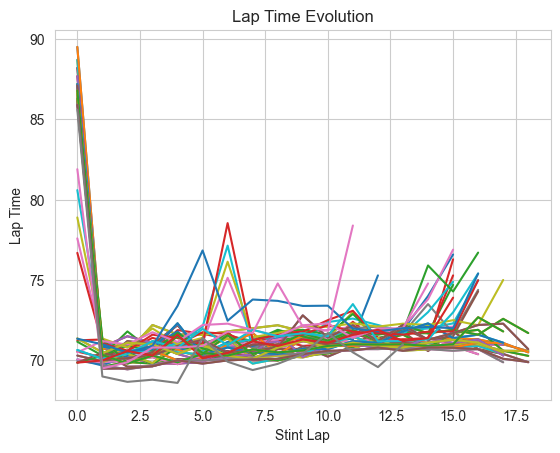

In [71]:
for i in range(len(stints)):
    if len(stints[i]) < 12: continue
    plt.plot(list(map(lambda x: x['lap_time'], stints[i])))
plt.title('Lap Time Evolution')
plt.xlabel('Stint Lap')
plt.ylabel('Lap Time')
plt.show()

In [94]:
lap_times = []
stds = []

for i in range(len(stints)):
    if len(stints[i]) < 12: continue
    times = (list(map(lambda x: x['lap_time'], stints[i])))[1:]
    if np.std(times) > 1.5: continue
    lap_times.append(times)

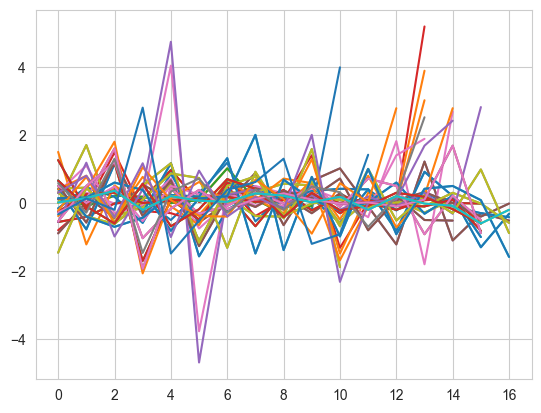

In [106]:
diffs = []
for i in range(len(lap_times)):
    diffs.extend(np.diff(lap_times[i]))
    plt.plot(np.diff(lap_times[i]))

Text(0.5, 0, 'Time Difference (seconds)')

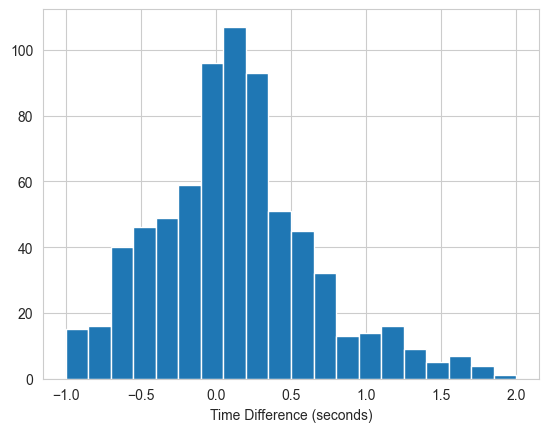

In [116]:
plt.hist(diffs, bins=20, range=[-1, 2])
plt.xlabel('Time Difference (seconds)')

In [119]:
lap_times

[[70.203186,
  70.303406,
  70.303406,
  70.68701,
  70.80383,
  70.30347,
  70.60364,
  71.788086,
  71.24609,
  71.50452,
  71.30432,
  75.29175],
 [69.60278,
  69.902954,
  69.80298,
  70.01965,
  70.20337,
  70.203125,
  70.286865,
  71.30444,
  71.4043,
  71.0874,
  71.00415],
 [69.60278,
  69.902954,
  69.80298,
  70.01965,
  70.20337,
  70.203125,
  70.286865,
  71.30444,
  71.4043,
  71.0874,
  71.00415],
 [71.304276,
  70.50348,
  70.40347,
  71.888214,
  71.65454,
  71.354675,
  70.80371,
  71.28772,
  70.90399,
  71.00409,
  72.40552,
  71.0874,
  71.104126,
  71.10425,
  76.292725],
 [70.50354,
  69.61096,
  69.63599,
  70.08655,
  70.00305,
  70.57031,
  70.00305,
  70.00305,
  70.88733,
  70.236694,
  70.88733,
  71.90503,
  71.80469,
  70.58716,
  71.80469,
  70.70386,
  70.403564,
  69.88623],
 [70.50354,
  69.61096,
  69.63599,
  70.08655,
  70.00305,
  70.57031,
  70.00305,
  70.00305,
  70.88733,
  70.236694,
  70.88733,
  71.90503,
  71.80469,
  70.58716,
  71.80469

In [120]:
def extract_dataset(lap_times, prediction_values=5):
    X = []
    y = []
    for stint in lap_times:
        for i in range(prediction_values, len(stint)-1):
            X.append(stint[i-prediction_values:i])
            y.append(stint[i+1])
    return X, y

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [178]:
window_size = 5

In [179]:
X, y = extract_dataset(lap_times, prediction_values=window_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Support Vector Regressor (SVR)": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

model_performance = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    model_performance[name] = {'MSE': mse, 'R^2 Score': r2}
    
model_performance_df = pd.DataFrame(model_performance)
print(model_performance_df)

           Linear Regression  Random Forest  Support Vector Regressor (SVR)  \
MSE                 0.339838       0.169596                        0.318164   
R^2 Score           0.358471       0.679845                        0.399385   

           K-Nearest Neighbors  Decision Tree  Gradient Boosting  
MSE                   0.312944       0.543245           0.264062  
R^2 Score             0.409239      -0.025512           0.501516  


In [197]:
pred = models["Random Forest"].predict(X_test_scaled)
diff = [p-t for p, t in zip(pred, y_test)]
diff = pd.DataFrame(diff, columns=['diff'])

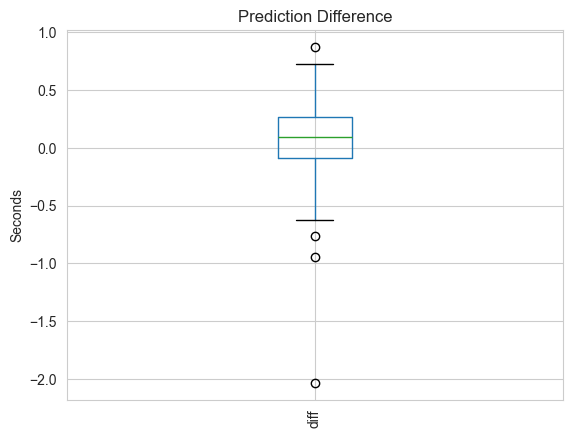

In [201]:
diff.boxplot(column='diff')
plt.title('Prediction Difference')
plt.suptitle('')  # Remove the default suptitle
plt.ylabel('Seconds')
plt.xticks(rotation=90)
plt.show()

In [202]:
diff.describe()

,diff
count,106.000000
mean,0.073814
std,0.407076
min,-2.032378
25%,-0.089218
50%,0.092788
75%,0.269811
max,0.872843


In [204]:
models["Random Forest"].

(<106x40580 sparse matrix of type '<class 'numpy.int64'>'
 	with 122290 stored elements in Compressed Sparse Row format>,
 array([    0,   395,   802,  1203,  1606,  1993,  2394,  2805,  3198,
         3609,  4010,  4415,  4828,  5227,  5638,  6047,  6458,  6873,
         7284,  7689,  8098,  8523,  8902,  9301,  9702, 10121, 10542,
        10941, 11344, 11753, 12162, 12559, 12980, 13383, 13776, 14185,
        14602, 15015, 15418, 15821, 16244, 16653, 17044, 17447, 17856,
        18265, 18664, 19083, 19488, 19885, 20282, 20695, 21118, 21519,
        21922, 22327, 22712, 23105, 23528, 23921, 24360, 24753, 25156,
        25563, 25976, 26391, 26814, 27217, 27640, 28057, 28456, 28855,
        29256, 29655, 30052, 30457, 30860, 31247, 31648, 32045, 32464,
        32871, 33276, 33701, 34100, 34511, 34930, 35341, 35762, 36179,
        36564, 36971, 37376, 37769, 38172, 38573, 38978, 39379, 39770,
        40183, 40580]))